### Aruco Board Generation

In [1]:
from PIL import Image
import numpy as np
import cv2

numMarkers = (6, 6)
markerLength = 0.04
markerSeparation = 0.01
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_50)
ids = np.array([i for i in range(numMarkers[0] * numMarkers[1])])

imageSize = (2048, 2048)
marginSize = 20
borderBits = 20

board = cv2.aruco.GridBoard(
    numMarkers,
    markerLength,
    markerSeparation,
    dictionary,
    ids
)
aruco_img = board.generateImage(
    imageSize,
    marginSize,
    borderBits
)
Image.fromarray(aruco_img).save("./aruco_board.png")

### Camera Calibration using Aruco Board

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import glob
import cv2

numMarkers = (6, 6)
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_50)
parameters =  cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, parameters)
board = cv2.aruco.GridBoard(
    numMarkers,
    markerLength = 2.7 * 0.01,
    markerSeparation = 0.7 * 0.01,
    dictionary = dictionary
)

corners = []
ids = []
obj_points = []
img_points = []
img_size = None

img_paths = glob.glob("./board/*.jpg")
for img_path in tqdm(img_paths):
    
    img = cv2.imread(img_path)
    img_size = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_corners, img_ids, rejected_corners = detector.detectMarkers(gray)
    
    # Feat 1: Can refine undetected markers
    img_corners, img_ids, rejected_corners, recovered_ids = detector.refineDetectedMarkers(
        img,
        board,
        img_corners,
        img_ids,
        rejected_corners
    )

    po, pi = board.matchImagePoints(img_corners, img_ids)
    
    corners.append(img_corners)
    ids.append(img_ids)
    obj_points.append(po)
    img_points.append(pi)

cameraMatrix = np.array([
    [3.44390335e+03, 0.00000000e+00, 2.05169588e+03],
    [0.00000000e+00, 3.43609811e+03, 1.48882711e+03],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])
# Feat 2: Can setup a more accurate distortion model
distCoeffs = np.array([ 0.24383907, -1.06087042, -0.00386441,  0.00137605,  1.27715562])
# err = cv2.calibrateCamera(obj_points, img_points, img_size, cameraMatrix, distCoeffs)

### Plotting the Markers and the Board Pose

In [ ]:
from PIL import Image

idx = 1
img = cv2.imread(img_paths[idx])
retval, rvec, tvec = cv2.solvePnP(
    obj_points[idx],
    img_points[idx],
    cameraMatrix,
    distCoeffs
)
proj = cv2.aruco.drawDetectedMarkers(img.copy(), corners[idx], ids[idx])
pose = cv2.drawFrameAxes(proj.copy(), cameraMatrix, distCoeffs, rvec, tvec, length=0.1);
Image.fromarray(pose).save("proj.png")

### Pose Estimation of the Image Plane

In [2]:
from tqdm.notebook import tqdm
import glob
import cv2

numMarkers = (6, 6)
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_50)
parameters =  cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, parameters)
board = cv2.aruco.GridBoard(
    numMarkers,
    markerLength = 2.7 * 0.01,
    markerSeparation = 0.7 * 0.01,
    dictionary = dictionary
)

corners = []
ids = []
rvecs = []
tvecs = []
img_size = None

cameraMatrix = np.array([
    [3.44390335e+03, 0.00000000e+00, 2.05169588e+03],
    [0.00000000e+00, 3.43609811e+03, 1.48882711e+03],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])
distCoeffs = np.array([ 0.24383907, -1.06087042, -0.00386441,  0.00137605,  1.27715562])

img_paths = glob.glob("./imgs/*.jpg")
for img_path in tqdm(img_paths):
    
    img = cv2.imread(img_path)
    img_size = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_corners, img_ids, rejected_corners = detector.detectMarkers(gray)
    
    img_corners, img_ids, rejected_corners, recovered_ids = detector.refineDetectedMarkers(
        img,
        board,
        img_corners,
        img_ids,
        rejected_corners
    )

    obj_points, img_points = board.matchImagePoints(img_corners, img_ids)

    retval, rvec, tvec = cv2.solvePnP(
        obj_points,
        img_points,
        cameraMatrix,
        distCoeffs
    )
    rvecs.append(rvec)
    tvecs.append(tvec)
    corners.append(img_corners)
    ids.append(img_ids)

  0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
def compute_camera_pose(rvecs, tvecs):
    rvec_wcs = []
    t_wcs = []
    for rvec, tvec in zip(rvecs, tvecs):
        R_oc, _ = cv2.Rodrigues(rvec)
        R_wc = R_oc.T
        t_wc = -R_wc @ tvec
        rvec_wc, _ = cv2.Rodrigues(R_wc)
        rvec_wcs.append(rvec_wc)
        t_wcs.append(t_wc)
    return rvec_wcs, t_wcs

rvec_wcs, t_wcs = compute_camera_pose(rvecs, tvecs)

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_camera(ax, R_wc, t_wc, scale=0.5):
    """
    Plots a simple representation of a camera in 3D space.

    Parameters:
    - ax: Matplotlib 3D axes.
    - R_wc: Rotation matrix from world to camera coordinates.
    - t_wc: Translation vector from world to camera coordinates.
    - scale: Size of the image plane representation.
    """
    theta = np.radians(180)
    R_transform = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, -1]
    ])

    # Apply the transformation to the rotation matrix and translation vector
    R_wc = R_transform @ R_wc
    t_wc = R_transform @ t_wc
    
    # Define the corners of the image plane in camera coordinates
    w = scale  # Width of the image plane
    h = scale  # Height of the image plane
    z = scale  # Distance from camera center to image plane

    # Corners in camera coordinates (shape: 4x3)
    image_plane_corners = np.array([
        [-w/2,  h/2, z],  # Top-left
        [ w/2,  h/2, z],  # Top-right
        [ w/2, -h/2, z],  # Bottom-right
        [-w/2, -h/2, z],  # Bottom-left
    ])

    # Transform corners to world coordinates
    image_plane_corners_w = image_plane_corners @ R_wc.T + t_wc.reshape(1, 3)
    camera_center_w = t_wc.reshape(1, 3)  # Camera center in world coordinates

    # Plot the image plane as a polygon
    verts = [list(zip(image_plane_corners_w[:, 0], image_plane_corners_w[:, 1], image_plane_corners_w[:, 2]))]
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.25))

    # Plot lines from camera center to each corner of the image plane
    for i in range(4):
        x = [camera_center_w[0, 0], image_plane_corners_w[i, 0]]
        y = [camera_center_w[0, 1], image_plane_corners_w[i, 1]]
        z = [camera_center_w[0, 2], image_plane_corners_w[i, 2]]
        ax.plot(x, y, z, color='blue')

    # Optionally, plot the camera center
    ax.scatter(camera_center_w[0, 0], camera_center_w[0, 1], camera_center_w[0, 2], color='red', marker='o')

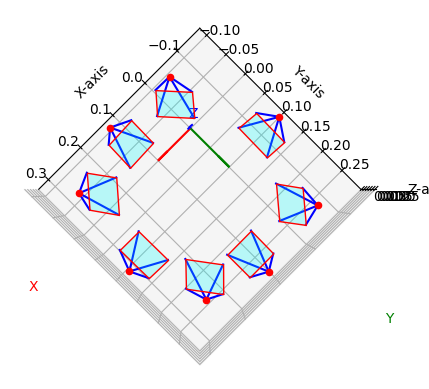

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

origin = np.array([[0, 0, 0]])
ax.quiver(origin[:,0], origin[:,1], origin[:,2], [1], [0], [0], color='r', length=0.1)
ax.quiver(origin[:,0], origin[:,1], origin[:,2], [0], [1], [0], color='g', length=0.1)
ax.quiver(origin[:,0], origin[:,1], origin[:,2], [0], [0], [1], color='b', length=0.1)

ax.text(0.5, 0, 0, 'X', color='r')
ax.text(0, 0.5, 0, 'Y', color='g')
ax.text(0, 0, 0.5, 'Z', color='b')

for rvec_wc, t_wc in zip(rvec_wcs, t_wcs):
    R_wc, _ = cv2.Rodrigues(rvec_wc)
    plot_camera(ax, R_wc, t_wc, scale=0.07)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.view_init(elev=90, azim=45)
plt.show()

In [ ]:
import imageio
import os

img_paths = sorted(glob.glob("./imgs/*.jpg"))
frames = []
for img_path in img_paths:
    img = imageio.imread(img_path)
    frames.append(img)
imageio.mimsave(os.path.join(".", "anime.mp4"), frames, codec='libx264', fps=4, quality=10)
# imageio.mimsave(os.path.join(".", "anime.gif"), frames, format='GIF', fps=4, loop=0)

In [ ]:
import imageio
import os

img_paths = sorted(glob.glob("./imgs/*.jpg"))
writer = imageio.get_writer('test.mp4', fps=4)
for img_path in img_paths:
    img = imageio.imread(img_path)
    writer.append_data(img)
writer.close()

In [ ]:
idx = 1
img = cv2.imread(img_paths[idx])
proj = cv2.aruco.drawDetectedMarkers(img.copy(), corners[idx], ids[idx])
pose = cv2.drawFrameAxes(proj.copy(), cameraMatrix, distCoeffs, rvecs[idx], tvecs[idx], length=0.1);
Image.fromarray(pose).save("proj.png")

### Generating the Visual Hull

In [ ]:
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import glob
import cv2
import json

numMarkers = (6, 6)
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_50)
parameters =  cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, parameters)
board = cv2.aruco.GridBoard(
    numMarkers,
    markerLength = 2.7 * 0.01,
    markerSeparation = 0.7 * 0.01,
    dictionary = dictionary
)

def get_Rx(theta: float) -> np.ndarray:
    theta = np.radians(theta)
    R_x = np.array([
        [1, 0,           0          ],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta),  np.cos(theta)]
    ])
    return R_x

cameraMatrix = np.array([
    [3.44390335e+03, 0.00000000e+00, 2.05169588e+03],
    [0.00000000e+00, 3.43609811e+03, 1.48882711e+03],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])
distCoeffs = np.array([ 0.24383907, -1.06087042, -0.00386441,  0.00137605,  1.27715562])
T = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, -1]
])

def compute_pose(img: np.ndarray):
    img_size = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_corners, img_ids, rejected_corners = detector.detectMarkers(gray)
    
    img_corners, img_ids, rejected_corners, recovered_ids = detector.refineDetectedMarkers(
        img,
        board,
        img_corners,
        img_ids,
        rejected_corners
    )
    
    obj_points, img_points = board.matchImagePoints(img_corners, img_ids)
    
    retval, rvec, tvec = cv2.solvePnP(
        obj_points,
        img_points,
        cameraMatrix,
        distCoeffs
    )

    rvec, tvec = cv2.solvePnPRefineLM(
        obj_points,
        img_points,
        cameraMatrix,
        distCoeffs,
        rvec,
        tvec
    )
    
    R_oc, _ = cv2.Rodrigues(rvec)
    R_wc = T @ R_oc.T
    t_wc = -R_wc @ tvec
    return R_wc, t_wc, rvec, tvec

def rgb_to_hex(rgb):
    return '#{:02X}{:02X}{:02X}'.format(*rgb)

In [ ]:
img_paths = glob.glob("./imgs/*.jpg")
mask_paths = glob.glob("./masks/*.png")

bounds = np.array([
    [0, 0, 0],
    [0.2, 0.2, 0.2]
])
n_vxls = np.array([150, 150, 150])
volume = np.zeros(n_vxls, dtype=np.uint8)
intensities = np.zeros((*list(n_vxls), 3), dtype=np.float16)
step = (bounds[1] - bounds[0]) / n_vxls

xi = np.arange(n_vxls[0])
yi = np.arange(n_vxls[1])
zi = np.arange(n_vxls[2])
indices = np.stack(np.meshgrid(xi, yi, zi, indexing='ij'), axis=-1)

centers = bounds[0] + step / 2.0 + step * indices
centers = centers.reshape(-1, 3)

_fx = cameraMatrix[0, 0]
_fy = cameraMatrix[1, 1]
_cx = cameraMatrix[0, 2]
_cy = cameraMatrix[1, 2]

N = len(img_paths)

for idx in tqdm(range(N)):

    img = np.array(Image.open(img_paths[idx]))
    mask = np.array(Image.open(mask_paths[idx]).convert("L").resize(img.shape[:2]))
    R_wc, t_wc, rvec, tvec = compute_pose(img)

    img_points, jacobian = cv2.projectPoints(
        centers,
        rvec,
        tvec,
        cameraMatrix,
        distCoeffs
    )
    
    [x, y, z] = ((centers - t_wc.reshape(1, 3)) @ R_wc).T
    x_proj = (np.rint(x / z * _fx + _cx)).astype(np.int32)
    y_proj = (np.rint(y / z * _fy + _cy)).astype(np.int32)

    [x_proj, y_proj] = np.rint(img_points.squeeze(1)).astype(np.int32).T
    
    H, W = mask.shape
    valid = (x_proj >= 0) & (x_proj < W) & (y_proj >= 0) & (y_proj < H)
    x_proj = np.clip(x_proj, 0, W-1)
    y_proj = np.clip(y_proj, 0, H-1)
    
    valid_voxels = (valid & (mask[y_proj, x_proj] > 0)).reshape(n_vxls)
    voxel_indices = indices[valid_voxels]
    
    x_idx, y_idx, z_idx = voxel_indices.T
    volume[x_idx, y_idx, z_idx] += 1
    # I = (img[y_proj, x_proj].astype(np.float16) * valid.astype(np.float16)[:, None]).reshape((*list(n_vxls), 3))
    # intensities += I

# intensities /= N
# intensities = np.clip(np.rint(intensities), a_min=0, a_max=255).astype(int)

thres = 2
data = {
    "version": "Voxel Builder 4.5.1",
    "project": {
        "name": "naruto",
        "voxels": int(np.sum(volume >= thres))
    },
    "data": {
        "voxels": ";".join([f"{v[0]},{v[1]},{v[2]},{rgb_to_hex(v)},1" for v in zip(*np.where(volume >= thres))])
    }
}
with open('model.json', 'w') as fp:
    json.dump(data, fp)

In [ ]:
volume.max()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_camera(ax, R_wc, t_wc, scale=0.5):
    
    # Define the corners of the image plane in camera coordinates
    w = scale  # Width of the image plane
    h = scale  # Height of the image plane
    z = scale  # Distance from camera center to image plane

    # Corners in camera coordinates (shape: 4x3)
    image_plane_corners = np.array([
        [-w/2,  h/2, z],  # Top-left
        [ w/2,  h/2, z],  # Top-right
        [ w/2, -h/2, z],  # Bottom-right
        [-w/2, -h/2, z],  # Bottom-left
    ])

    # Transform corners to world coordinates
    image_plane_corners_w = image_plane_corners @ R_wc.T + t_wc.reshape(1, 3)
    # camera_center_w = t_wc.reshape(1, 3)  # Camera center in world coordinates
    camera_center_w = np.stack((np.zeros((20)), np.zeros(20), np.arange(20) / 50)).T @ R_wc.T + t_wc.reshape(1, 3)

    # Plot the image plane as a polygon
    verts = [list(zip(image_plane_corners_w[:, 0], image_plane_corners_w[:, 1], image_plane_corners_w[:, 2]))]
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.25))

    # Plot lines from camera center to each corner of the image plane
    for i in range(4):
        x = [camera_center_w[0, 0], image_plane_corners_w[i, 0]]
        y = [camera_center_w[0, 1], image_plane_corners_w[i, 1]]
        z = [camera_center_w[0, 2], image_plane_corners_w[i, 2]]
        ax.plot(x, y, z, color='blue')

    # Optionally, plot the camera center
    ax.scatter(camera_center_w[:, 0], camera_center_w[:, 1], camera_center_w[:, 2], color='red', marker='o')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

origin = np.array([[0, 0, 0]])
ax.quiver(origin[:,0], origin[:,1], origin[:,2], [1], [0], [0], color='r', length=0.1)
ax.quiver(origin[:,0], origin[:,1], origin[:,2], [0], [1], [0], color='g', length=0.1)
ax.quiver(origin[:,0], origin[:,1], origin[:,2], [0], [0], [1], color='b', length=0.1)

ax.text(0.5, 0, 0, 'X', color='r')
ax.text(0, 0.5, 0, 'Y', color='g')
ax.text(0, 0, 0.5, 'Z', color='b')

for img_path in img_paths:

    img = np.array(Image.open(img_path))
    R_wc, t_wc = compute_pose(img)
    plot_camera(ax, R_wc, t_wc, scale=0.07)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
# ax.set_xlim(0.05, 0.15)
# ax.set_ylim(0.05, 0.15)
# ax.set_zlim(0.05, 0.15)
ax.view_init(elev=0, azim=0)
plt.show()

In [ ]:
x, y, z = np.where(volume)
new_volume = volume.copy()
new_volume[np.clip(x + 1, a_min=0, a_max=99)] = 1
new_volume[np.clip(x - 1, a_min=0, a_max=99)] = 1
new_volume[np.clip(y + 1, a_min=0, a_max=99)] = 1
new_volume[np.clip(y - 1, a_min=0, a_max=99)] = 1
new_volume[np.clip(z + 1, a_min=0, a_max=99)] = 1
new_volume[np.clip(z - 1, a_min=0, a_max=99)] = 1

data = {
    "version": "Voxel Builder 4.5.1",
    "project": {
        "name": "naruto",
        "voxels": int(np.sum(new_volume))
    },
    "data": {
        "voxels": ";".join([f"{v[0]},{v[1]},{v[2]},#EE4B2B,1" for v in zip(*np.where(new_volume))])
    }
}
with open('model.json', 'w') as fp:
    json.dump(data, fp)

In [ ]:
new_volume = np.zeros_like(volume, dtype=np.uint8)
offsets = np.array([
    [dx, dy, dz]
    for dx in [-1, 0, 1]
    for dy in [-1, 0, 1]
    for dz in [-1, 0, 1]
])
for x, y, z in zip(*np.where(volume >= len(images))):
    new_volume[tuple(np.clip(np.array([x, y, z]) + offsets, a_min=0, a_max=reso-1).T)] = 1
data = {
    "version": "Voxel Builder 4.5.1",
    "project": {
        "name": "naruto",
        "voxels": int(np.sum(new_volume))
    },
    "data": {
        "voxels": ";".join([
            f"{v[0]},{v[1]},{v[2]},#EE4B2B,1"
            for v in zip(*np.where(new_volume > 0))
        ])
    }
}
with open('model.json', 'w') as fp:
    json.dump(data, fp)